# No-FICO Defaults & Charge-off Prediction

## Data Preprocessing

In [22]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_pickle("../data/cleaned.pkl")
df = df.dropna()

## Feature Engineering

In [3]:
# print data types of all columns
df.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 77, dtype: object

In [4]:
# print the variables in the dataset
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc',

In [5]:
# drop zip code and state columns
df.drop(['zip_code', 'addr_state'], axis=1, inplace=True)

### Dummy Variables

In [6]:
# one hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

In [7]:
df.columns = df.columns.astype(str)
df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

In [8]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,last_credit_pull_d_Oct_2015,last_credit_pull_d_Sep_2007,last_credit_pull_d_Sep_2008,last_credit_pull_d_Sep_2009,last_credit_pull_d_Sep_2010,last_credit_pull_d_Sep_2011,last_credit_pull_d_Sep_2012,last_credit_pull_d_Sep_2013,last_credit_pull_d_Sep_2014,last_credit_pull_d_Sep_2015
0,5000.0,5000.0,4975.0,10.65,162.87,10.0,24000.0,0.0,27.65,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,15.27,59.83,0.5,30000.0,1.0,1.00,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2400.0,2400.0,2400.0,15.96,84.33,10.0,12252.0,0.0,8.72,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,13.49,339.31,10.0,49200.0,0.0,20.00,0.0,...,0,0,0,0,0,0,0,0,0,0
5,5000.0,5000.0,5000.0,7.90,156.46,3.0,36000.0,0.0,11.20,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421080,10775.0,10775.0,10775.0,6.03,327.95,0.5,54000.0,0.0,13.22,1.0,...,0,0,0,0,0,0,0,0,0,0
421082,6225.0,6225.0,6225.0,16.49,220.37,2.0,27000.0,0.0,18.58,0.0,...,0,0,0,0,0,0,0,0,0,0
421085,4000.0,4000.0,4000.0,8.67,126.59,10.0,50000.0,0.0,12.63,0.0,...,0,0,0,0,0,0,0,0,0,0
421086,10850.0,10850.0,10850.0,19.24,399.04,0.0,32000.0,1.0,29.44,0.0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split

In [9]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Model Building

### Random Forest

#### Model Training

In [10]:
# Load model
rf = pickle.load(open('../models/rf_model.pkl', 'rb'))

In [11]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=7,
                       min_samples_split=4, n_estimators=142, random_state=42)

#### Model Evaluation

In [12]:
# Print classification report
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     67599
         1.0       0.84      0.83      0.83     21294

    accuracy                           0.92     88893
   macro avg       0.89      0.89      0.89     88893
weighted avg       0.92      0.92      0.92     88893



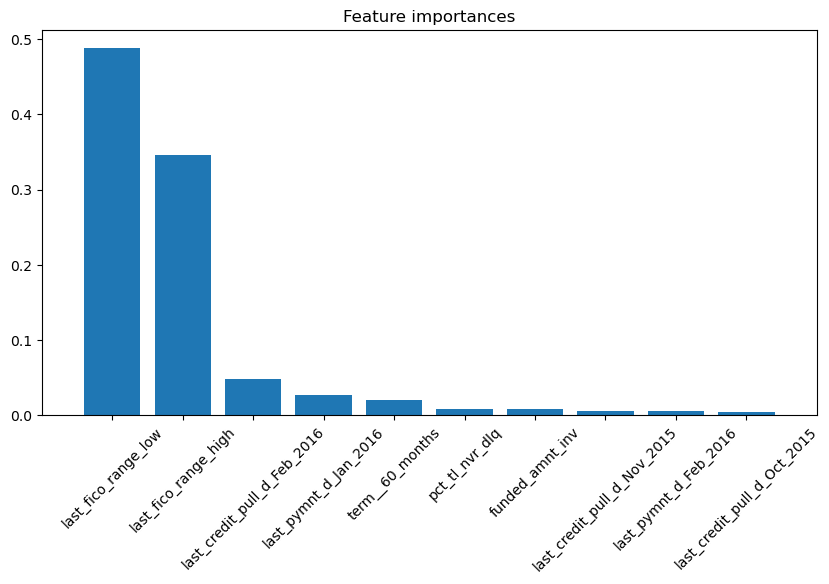

In [13]:
# plot feature importances top 10
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), X_train.columns[indices], rotation=45)
plt.xlim([-1, 10])
plt.show()

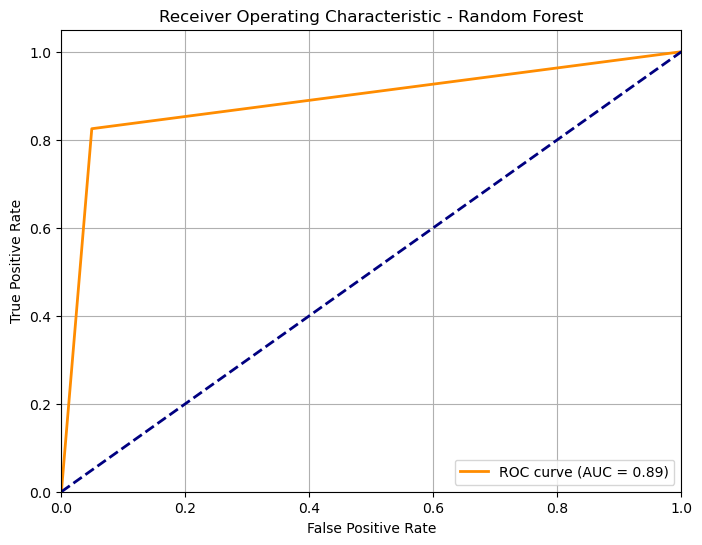

In [14]:
# plot roc curve
utils.plot_roc_curve(y_test, y_pred_rf_test, model_name='Random Forest')

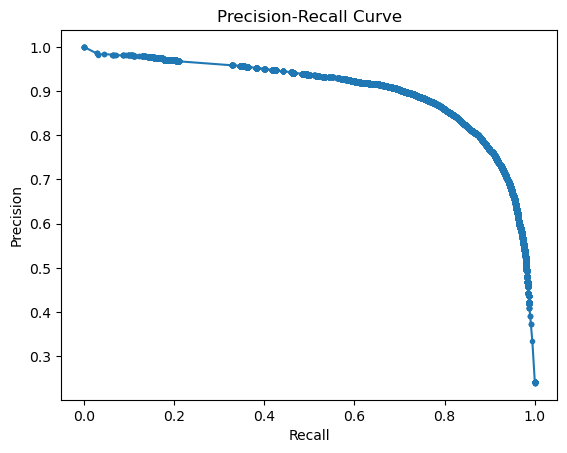

In [18]:
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

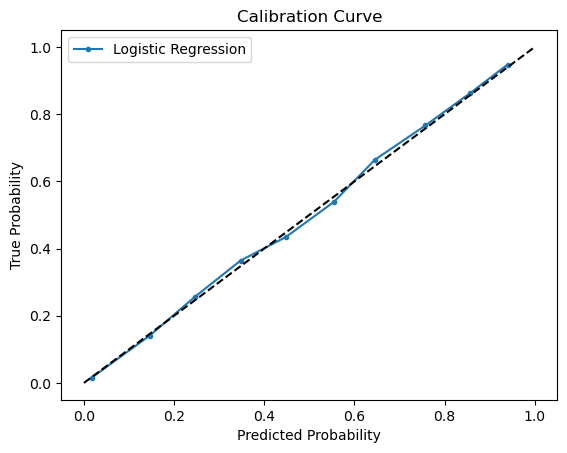

In [20]:
prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)
plt.plot(prob_pred, prob_true, marker='.', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

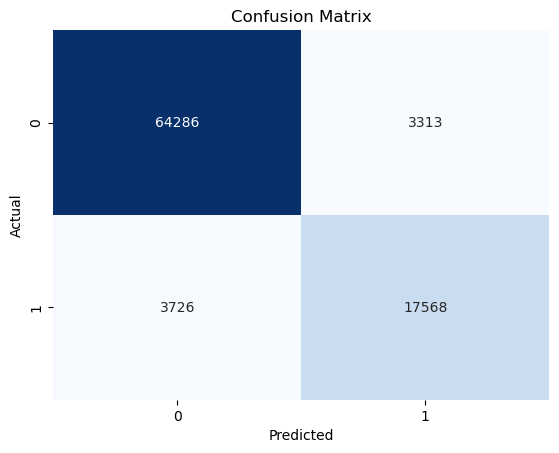

In [23]:
cm = confusion_matrix(y_test, y_pred_rf_test)
plt.plot()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
models = ['Random Forest']
predictions_train = [y_pred_rf_train]
predictions_test = [y_pred_rf_test]

utils.evaluate_models(models=models, predictions_train=predictions_train, predictions_test=predictions_test, X=X,
                      y_train=y_train, y_test=y_test)

,,Random Forest
Metric,Type,
Accuracy,Train,0.923385
Overall Precision,Train,0.923034
Overall Recall,Train,0.923385
Overall F1 Score,Train,0.923196
Positive Precision,Train,0.845017
Negative Precision,Train,0.947609
Positive Recall,Train,0.832924
Negative Recall,Train,0.95188
Positive F1 Score,Train,0.838927
